### Lecture 1, step 3, Cepstrum:
Simple homomorphic processing example

In this notebook, we demonstrate use of cepstrum for source/excitation-filter separation. The main function that performs these operations is 'lifterSpectrogram' which takes in the windowed signal and returns spectra and cepstrum. This notebook does not have a student version.


In [1]:
import os
import sys
import numpy as np
import essentia.standard as ess
from scipy.fftpack import fft,ifft
from scipy.signal import get_window
import matplotlib.pyplot as plt

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import IPython.display as ipd

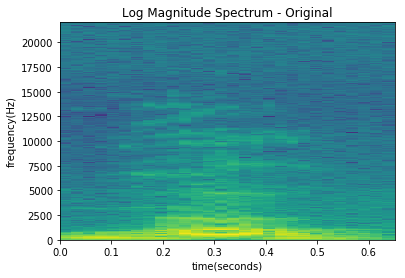

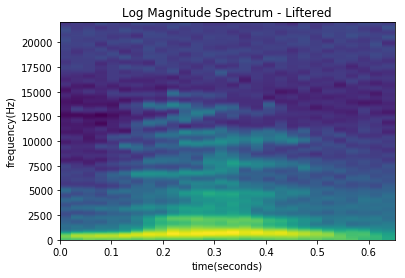

In [2]:
def lifterSpectrogram(x_win,fftN,numCepsCoefs):
    '''Liftering applied to time domain signal
    Parameters
    ----------
    x_win,fftN,numCepsCoefs: np.array,int,int
        Windowed signal, number of fft coeffs., 
        number of cepstral coefficients to keep for the filter
    
    Returns
    -------
    ceps,logSpec,filterSpec,sourceSpec: np.array
        Real cepstrum, log amplitude spectra: 
            - original, filter-only version, excitation-only version 
    ''' 

    absX=np.abs(fft(x_win,fftN))#computing amplitude sectrogram
    absX[absX<np.finfo(float).eps]=np.finfo(float).eps#getting rid of zeros before the next step
    logSpec=np.log10(absX)
    ceps=np.real(ifft(logSpec,fftN))#Real cepstrum
    filterCeps=np.copy(ceps)
    filterCeps[numCepsCoefs+1:-(numCepsCoefs-1)]=0#suppressing excitation components
    filterSpec=np.real(fft(filterCeps,fftN))
    sourceCeps=np.copy(ceps)
    sourceCeps[:numCepsCoefs+1]=0#suppressing filter components
    sourceCeps[-(numCepsCoefs-1):]=0#suppressing filter components
    sourceSpec=np.real(fft(sourceCeps,fftN))
    return (ceps[:fftN/2],logSpec[:fftN/2],filterSpec[:fftN/2],sourceSpec[:fftN/2])
#------------------------

#Initialize parameters
soundsDIR='../data/baris/'
windowSize=2048
hopSize=windowSize/2
windowFunction='blackman'
fs=44100
fftN=2048
numCepsCoefs=50
#Create the window function
w = get_window(windowFunction, windowSize)

#Read and normalize the signal
x = ess.MonoLoader(filename = soundsDIR+'waw.wav', sampleRate = fs)()
x=x/np.max(np.abs(x))
#Compute required parameters for windowing
startIndexes=np.arange(0, x.size-windowSize,hopSize, dtype=int)
numWindows=startIndexes.size

spect = []
cepst = []
spect_filtOnly = []
spect_sourceOnly = []
for k in range(numWindows):
    startInd=startIndexes[k]
    x_win=x[startInd:startInd+windowSize]*w
    ceps,logSpec,filterSpec,sourceSpec=lifterSpectrogram(x_win,fftN,numCepsCoefs)
    spect.append(logSpec)
    cepst.append(ceps)
    spect_filtOnly.append(filterSpec)
    spect_sourceOnly.append(sourceSpec)
    
spect=np.array(spect)
cepst=np.array(cepst)
spect_filtOnly=np.array(spect_filtOnly)
spect_sourceOnly=np.array(spect_sourceOnly)

#Plotting the spectrogram(matrix)
timeAxSec=np.arange(spect.shape[0])*hopSize/float(fs)
freqAx_normalized=np.arange(spect.shape[1])/float(fftN)#Normalized frequency axis
freqAxHz=float(fs)*freqAx_normalized

plt.pcolormesh(timeAxSec,freqAxHz,np.transpose(spect))
plt.xlim([0,timeAxSec[-1]])
plt.ylim([0,freqAxHz[-1]])
plt.title('Log Magnitude Spectrum - Original')
plt.ylabel('frequency(Hz)')
plt.xlabel('time(seconds)')
plt.show()

plt.pcolormesh(timeAxSec,freqAxHz,np.transpose(spect_filtOnly))
plt.xlim([0,timeAxSec[-1]])
plt.ylim([0,freqAxHz[-1]])
plt.title('Log Magnitude Spectrum - Liftered')
plt.ylabel('frequency(Hz)')
plt.xlabel('time(seconds)')
plt.show()


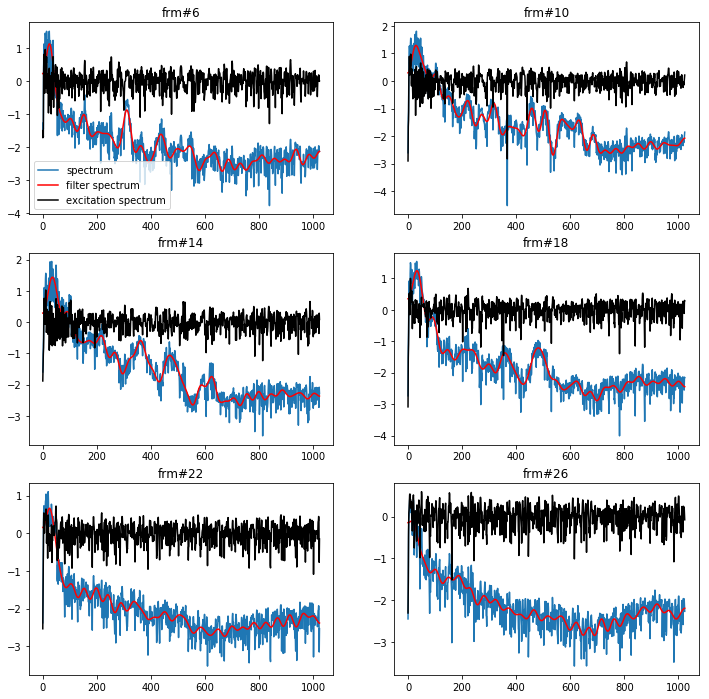

In [3]:
#Plotting sample frames
numFrm2plot=6
plt.figure(figsize=(12, numFrm2plot*2))
plotInd=1
for k in range(numFrm2plot,spect.shape[0],int(spect.shape[0]/numFrm2plot)):
    plt.subplot(numFrm2plot/2,2, plotInd)
    plt.plot(spect[k,:],label='spectrum')
    plt.plot(spect_filtOnly[k,:],'r',label='filter spectrum')
    plt.plot(spect_sourceOnly[k,:],'k',label='excitation spectrum')
    plt.title('frm#'+str(k))
    if plotInd==1:
        plt.legend(loc='best')
    plotInd+=1

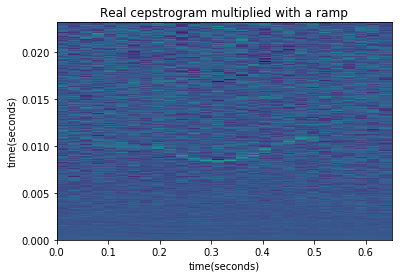

In [4]:
#Cepstrum for period/pitch detection
# Here we will simply plot cepstrum after re-shaping by multiplying with a ramp
# We expect to see a trace of fundamental period on the plot
ramp=np.arange(0,1,1/cepst.shape[1])
for k in range(cepst.shape[0]):
    cepst[k,:]=cepst[k,:]*ramp

timeAxSec_y=np.arange(cepst.shape[1])/float(fs)
plt.pcolormesh(timeAxSec,timeAxSec_y,np.transpose(cepst))
plt.title('Real cepstrogram multiplied with a ramp')
plt.ylabel('time(seconds)')
plt.xlabel('time(seconds)')
plt.show()